# 時系列モデル

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random
import gc
from collections import defaultdict


In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'memory_length': 5,
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.005,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
N_SPLITS = 5
DEBUG = False
MAX_EPOCHS = 500
if DEBUG:
    MAX_EPOCHS = 1


MEMORY_LENGTH = config['memory_length']
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 60
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_base25_withpassedtime_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_base25_withpassedtime_allwifibase_withdelta.csv')

In [13]:
train_df.sort_values(['path_id', 'passed_time'])

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,passed_time,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
15937,44aebad0d3851fd527d792ef1af44d24f41b5799,cba67c1d9d22c3847bc71e06c955fb90d616f4d4,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,da39a3ee5e6b4b0d3255bfef95601890afd80709,854f47d243fa7a56de9e293d736999eb756dd488,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,...,1965,1560500995805,198.05206,93.97124,2.0,F3,5d073b814a19c000086c558b,5c3c44b80379370013e0fd2b,0.000000,0.000000
15938,cba67c1d9d22c3847bc71e06c955fb90d616f4d4,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,...,3876,1560500995805,198.05206,93.97124,2.0,F3,5d073b814a19c000086c558b,5c3c44b80379370013e0fd2b,0.000000,0.000000
15939,cba67c1d9d22c3847bc71e06c955fb90d616f4d4,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,854f47d243fa7a56de9e293d736999eb756dd488,44aebad0d3851fd527d792ef1af44d24f41b5799,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,...,5785,1560500995805,198.05206,93.97124,2.0,F3,5d073b814a19c000086c558b,5c3c44b80379370013e0fd2b,0.000000,0.000000
15940,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,da39a3ee5e6b4b0d3255bfef95601890afd80709,cba67c1d9d22c3847bc71e06c955fb90d616f4d4,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,...,7711,1560500995805,198.05206,93.97124,2.0,F3,5d073b814a19c000086c558b,5c3c44b80379370013e0fd2b,0.000000,0.000000
15941,cba67c1d9d22c3847bc71e06c955fb90d616f4d4,da39a3ee5e6b4b0d3255bfef95601890afd80709,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,44aebad0d3851fd527d792ef1af44d24f41b5799,...,9637,1560501011427,180.07335,89.94896,2.0,F3,5d073b814a19c000086c558b,5c3c44b80379370013e0fd2b,-13.370739,-3.282570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,c7f3961845ceed4962bc8e513b34d57c790e807c,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,c451965585f1bd709a952b68f8c89df943c01065,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,10018,1578483477240,106.65901,154.62952,-1.0,B1,5e15bf941506f2000638fec5,5a0546857ecc773753327266,-1.699576,4.860221
528,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,c7f3961845ceed4962bc8e513b34d57c790e807c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,356d66c73c423be835bd5d07cb1ebdfa821d8e23,da39a3ee5e6b4b0d3255bfef95601890afd80709,e7b41da4e10e07fea88266ee47cf227edbd22e49,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,...,12023,1578483477240,106.65901,154.62952,-1.0,B1,5e15bf941506f2000638fec5,5a0546857ecc773753327266,-1.699576,4.860221
529,5a368e0bd5050bdb465

In [14]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [15]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']
FLOOR_TGTS = [f'floor_{i}' for i in range(11)]

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [16]:
# def del_longdata(tgt_df):

#     df_ = tgt_df.copy()
#     del_path = []
#     new_trains = []
#     for i, (p, g) in tqdm(enumerate(df_.groupby('path_id'))):
#         if len(g) > MEMORY_LENGTH:
#             del_path.append(p)
#             for j in range((len(g) // MEMORY_LENGTH) + 1):
#                 if j == (len(g) // MEMORY_LENGTH):
#                     tmp = g.iloc[j*MEMORY_LENGTH:]
#                 else:
#                     tmp = g.iloc[j*MEMORY_LENGTH:(j+1)*MEMORY_LENGTH]
#                 tmp.loc[:, 'path_id'] = p + '_' + str(j)
#                 new_trains.append(tmp)

#     df_.drop(df_[df_['path_id'].isin(del_path)].index, inplace=True)
#     df_ = pd.concat([df_, pd.concat(new_trains)]).reset_index(drop=True)
#     print(f"previous path len:{i+1}, current path len:{len(df_.groupby('path_id'))}")
#     return df_

# train_data = del_longdata(train_df)

In [18]:
X_train = train_df.loc[:, ['passed_time', 'site_id',
                             'path_id'] + BSSID_FEATS + RSSI_FEATS + DELTA_FEATS]
y_train = train_df.loc[:, ['passed_time', 'path_id', 'x', 'y', 'site_id']]
X_test = test_df.loc[:, ['passed_time', 'site_id',
                           'path_id'] + BSSID_FEATS + RSSI_FEATS + DELTA_FEATS]

In [20]:
floor_df = pd.DataFrame(np.identity(len(train_df['floor'].unique()))[train_df['floor'].values.astype(int)], columns=FLOOR_TGTS)
y_train = pd.concat([y_train, floor_df], axis=1)

### building weight

In [21]:
test_building_weight = defaultdict(int)
train_building_weight = defaultdict(int)
building_weight = dict()

for building in [x.split('_')[0] for x in sub.reset_index()['site_path_timestamp'].values]:
    test_building_weight[building] += 1 * 24/len(sub)
    
for building in train_df['site_id'].values:
    train_building_weight[building] += 1
train_building_weight = dict((k, len(train_df)/24/v) for k, v in train_building_weight.items())

for building in list(train_building_weight.keys()):
    building_weight[building] = train_building_weight[building] * test_building_weight[building]
    
y_train['weight'] = [building_weight[x] for x in y_train['site_id'].values]

In [22]:
# x_min = np.min(y_train.loc[:, 'x'].values)
# y_min = np.min(y_train.loc[:, 'y'].values)
# norm_x = np.max(y_train.loc[:, 'x'].values) - x_min
# norm_y = np.max(y_train.loc[:, 'y'].values) - y_min

# y_train.loc[:, 'x'] = (y_train.loc[:, 'x'] - x_min) / norm_x
# y_train.loc[:, 'y'] = (y_train.loc[:, 'y'] - y_min) / norm_y

In [23]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in BSSID_FEATS:
    wifi_bssids.extend(train_df.loc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in BSSID_FEATS:
    wifi_bssids_test.extend(test_df.loc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 60530
BSSID TYPES(test): 27662
BSSID TYPES(all): 88192


In [24]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 97
RSSI TYPES(test): 82
RSSI TYPES(all): 179


## PreProcess

In [25]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])

# ss_time = StandardScaler()
# ss_time.fit(train_df.loc[:,'passed_time'].values.reshape(1, -1))


def preprocess(input_df, le=le, le_site=le_site):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])
    
#     output_df.loc[:, 'passed_time'] = ss_time.transform(input_df.loc[:, 'passed_time'].values.reshape(1, -1)).reshape(-1)

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(input_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(X_train)
test = preprocess(X_test)

train  

,passed_time,site_id,path_id,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,...,rssi_72,rssi_73,rssi_74,rssi_75,rssi_76,rssi_77,rssi_78,rssi_79,delta_x,delta_y
0,2035,0,5e158ef61506f2000638fd1f,55275,21133,21114,39517,6525,10455,13296,...,21,21,20,20,20,20,20,20,-0.025217,-0.014531
1,4033,0,5e158ef61506f2000638fd1f,55275,21114,21133,49943,36964,19145,6525,...,23,23,22,22,22,22,22,22,0.446463,0.506216
2,6015,0,5e158ef61506f2000638fd1f,21114,55275,21133,19145,42070,28137,26133,...,26,26,25,25,25,25,24,24,0.446463,0.506216
3,8070,0,5e158ef61506f2000638fd1f,21114,21133,55275,26257,49943,58907,25174,...,25,25,25,25,25,24,24,24,0.446463,0.506216
4,10148,0,5e158ef61506f2000638fd1f,20984,26257,1030,14459,2367,20087,5791,...,29,28,28,28,27,27,27,27,0.504093,0.398055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251108,52286,23,5dcd5c9323759900063d590a,21186,49338,48466,12501,17915,59128,22658,...,0,0,0,0,0,0,0,0,0.121631,0.362279
251109,54230,23,5dcd5c9323759900063d590a,21186,12501,49338,48466,20486,44803,17915,...,0,0,0,0,0,0,0,0,-2.376529,0.568969
251110,56150,23,5dcd5c9323759900063d590a,12501,21186,48466,20486,44803,49338,17915,...,0,0,0,0,0,0,0,0,-2.376529,0.568969
251111,58085,23,5dcd5c9323759900063d590a,12501,49338,21186,57716,48466,17915,59128,...,0,0,0,0,0,0,0,0,-2.376529,0.568969


In [26]:
site_count = len(train['site_id'].unique())
site_count

24

In [27]:
concat_col = np.empty(2 * NUM_FEATS).astype(str)
concat_col[::2] = BSSID_FEATS
concat_col[1::2] = RSSI_FEATS
concat_col = ['site_id'] + list(concat_col) + DELTA_FEATS + ['passed_time']

In [28]:
def make_data(data, col):
    train_tmp = []
    path_ids = []
    for path_id_, group in tqdm(data.groupby('path_id')):
       
        group = group.sort_values('passed_time')
        if (len(group) <= MEMORY_LENGTH):
            train_tmp.append(group[col])
            path_ids.append(path_id_)     
        else:
            start = 0
            end = MEMORY_LENGTH
            while end <= len(group):
                train_tmp.append(group[col].iloc[start:end, :])
                path_ids.append(path_id_)   
                start += 1
                end += 1
        
    return train_tmp, path_ids
# train_cols = ['site_id'] + BSSID_FEATS + RSSI_FEATS + ['passed_time']
y_train_np, _ = np.array(make_data(y_train, col=['x', 'y', 'weight'] + FLOOR_TGTS))
X_train_np, path_ids = np.array(make_data(train, col=concat_col))

100%|██████████| 10789/10789 [02:15<00:00, 79.56it/s] 
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 10789/10789 [02:54<00:00, 61.70it/s] 
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## PyTorch model
- embedding layerが重要  

In [29]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, transform, inverse_ratio=0.5, combine_ratio=0.2):
        self.transform = transform
        self.x_train = x_train
        self.y_train = y_train
        self.inverse_ratio = inverse_ratio
        self.combine_ratio = combine_ratio

    def __getitem__(self, index):
        x = self.x_train[index].values
        y = self.y_train[index].values
        mask = np.full(MEMORY_LENGTH, True, dtype=bool)
        if len(x) < MEMORY_LENGTH:
            x_out = np.pad(x, ([(0, MEMORY_LENGTH - len(x)), (0, 0)]), 'edge')
            y_out = np.pad(y, ([(0, MEMORY_LENGTH - len(y)), (0, 0)]), 'edge')
            mask[len(x):] = False
        else:
            x_out = x
            y_out = y

#         if self.transform:
#             # inverse trajectory
#             if np.random.rand() < self.inverse_ratio:
#                 tmp = np.arange(MEMORY_LENGTH-1, -1, -1)
#                 x_out = x_out[tmp, :]
#                 y_out = y_out[tmp, :]
#                 mask = mask[tmp]

#             # # combine trajectory
#             if np.random.rand() < self.combine_ratio:
#                 p = np.random.permutation(list(range(MEMORY_LENGTH)))
#                 x_out = x_out[p]
#                 y_out = y_out[p]
#                 mask = mask[p]

        return x_out, y_out, mask

    def __len__(self):
        return len(self.x_train)

In [30]:
class ManyToMany(nn.Module):
    def __init__(self, wifi_bssids_size, input_dim, hidden_dim):
        super(ManyToMany, self).__init__()
        self.emb_dim = 256
        self.entitity_dim = 128
        self.delta_dim = 320
        self.bssi = nn.Embedding(wifi_bssids_size, self.emb_dim, max_norm=True)
        self.building = nn.Embedding(24, 2, max_norm=True)

     
        self.delta = nn.Sequential(
#             nn.BatchNorm1d(MEMORY_LENGTH*2),
            nn.Linear(MEMORY_LENGTH*2, self.delta_dim * MEMORY_LENGTH),
        )

        self.entity1 = nn.Sequential(
#             nn.BatchNorm1d(self.emb_dim + 2),
            nn.Linear(self.emb_dim + 2 + 2, self.entitity_dim),
            nn.ReLU(True)
        )
        self.entity2 = nn.Sequential(
#             nn.BatchNorm1d(MEMORY_LENGTH),
            nn.Dropout(0.2),
            nn.Linear(self.entitity_dim*NUM_FEATS*2, input_dim),
        )
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=3, bidirectional=True, batch_first=True)

        self.main = nn.Sequential(
            nn.BatchNorm1d(MEMORY_LENGTH),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, 32),
            nn.ReLU(True),
        )
        
        self.fc_xy = nn.Linear(32, 2)
        self.fc_floor = nn.Linear(32, 11)

    def forward(self, x):
        b_size = x.shape[0] 
        bssids = self.bssi(x[:, :, 1:int(NUM_FEATS*2+1)].long()).float()
        buildings = self.building(x[:, :, 0].long()).unsqueeze(2).expand(-1, -1, NUM_FEATS*2, -1).float()

        delta_feats = self.delta(x[:, :, -4:-2].flatten(start_dim=1).float())
        delta_feats = delta_feats.view(b_size, MEMORY_LENGTH, NUM_FEATS*2, -1)
        
        x = torch.cat((bssids, buildings, delta_feats), axis=3)
        #(batch, memory_length, wifi_num, self.emb_dim+2+1)
        x = self.entity1(x)
        #(batch, memory_length, wifi_num, self.entity1_dim)
        x = x.flatten(start_dim=2)
        #(batch, memory_length, wifi_num * self.entity1_dim)
        x = self.entity2(x)
        #(batch, memory_length, input_dim)
        output, _ = self.gru(x)
        output = self.main(output)
        
        xy_output = self.fc_xy(output)
        #(batch, memory_length, 2)
        floor_output = self.fc_floor(output)

        return xy_output, floor_output

In [31]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [32]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
def comp_metric_xy(output, y):
    return torch.sqrt((((output - y[:,:2]))**2).sum())


In [33]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = comp_metric_xy
        self.f_criterion = nn.BCEWithLogitsLoss()
    
    def training_step(self, batch, batch_idx):
        x, y, m = batch
        xy_output, floor_output = self.model(x)
        xy_loss = self.xy_criterion(xy_output[m], y[m][:, :2])
        f_loss = self.f_criterion(floor_output[m], y[m][:, 3:])
        return xy_loss + f_loss
    
    def validation_step(self, batch, batch_idx):
        x, y, m = batch
        output, _ = self.model(x)
        loss = self.xy_criterion(output[m], y[m][:, :2])
        mpe = mean_position_error(
            to_np(output[m][:, 0]), to_np(output[m][:, 1]), 0, 
            to_np(y[m][:, 0]), to_np(y[m][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
#         self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
#         self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [34]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    true_x = []
    true_y = []

    with torch.no_grad():
        for batch in loaders[phase]:
            x, y, m = batch
            output, _ = model(x)
            x_list.append(to_np(output[m][:, 0]))
            y_list.append(to_np(output[m][:, 1]))
            true_x.append(to_np(y[m][:, 0]))
            true_y.append(to_np(y[m][:, 1]))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    true_x = np.concatenate(true_x)
    true_y = np.concatenate(true_y)
#     f_list = np.concatenate(f_list)
    return x_list, y_list, true_x, true_y

## train

In [35]:
result = pd.DataFrame(np.zeros([len(test), 2]),
                     index=test.index, columns=['x', 'y'])

In [ ]:
# oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
oofs_x = []
oofs_y = []
trues_x = []
trues_y = []
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
prediction_x = 0
prediction_y = 0
val_counts = np.zeros(len(train))
oof_x_idx = np.zeros(len(train))
oof_y_idx = np.zeros(len(train))
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
# for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(path_ids, groups=path_ids)):


    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data

#     trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
#     val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
#     loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
#     loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
#     loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
  
    mtrain, mvalid = X_train_np[trn_idx], y_train_np[trn_idx]
    ltrain, lvalid = X_train_np[val_idx], y_train_np[val_idx]
    loaders["train"] = DataLoader(CustomDataset(
        mtrain, mvalid, transform=True), **loader_config["train"], worker_init_fn=worker_init_fn)
    loaders["valid"] = DataLoader(CustomDataset(
        ltrain, lvalid, transform=False), **loader_config["valid"], worker_init_fn=worker_init_fn)
    
    
    # model
#     model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model = ManyToMany(wifi_bssids_size+rssi_bssids_size, 64, 128)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])
    
    
    # prediction by sliding window averaging. see https://arxiv.org/pdf/1903.11703.pdf
    model.eval()
    prediction = []
    with torch.no_grad():
        for p, x in test.groupby('path_id'):
            window_score = defaultdict(list)
            x = x.sort_values('passed_time')
            ts = x['passed_time'].to_numpy()
            x = x[concat_col].reset_index(drop=True)

            for window in range(len(ts)):
                if MEMORY_LENGTH + window > len(ts):
                    break

                x_out = torch.tensor(
                    x.iloc[window:(window+MEMORY_LENGTH)].to_numpy())
                x_out = x_out.unsqueeze(0)
                x_out, _ = model(x_out)
                for i in range(MEMORY_LENGTH):
                    window_score[ts[window + i]].append(x_out.squeeze().cpu().detach().numpy()[i,:])

            #  sort by time and get average 
            window_score = sorted(window_score.items(), key=lambda x:x[0])
            prediction.extend(list(map(lambda x: np.mean(x[1],axis=0), window_score)))
    
    prediction = np.array(prediction)
    prediction_x += (prediction[:, 0]) / N_SPLITS
    prediction_y += (prediction[:, 1]) / N_SPLITS 
#     result['x'] += (prediction[:, 0] * norm_x + x_min) / FOLDS
#     result['y'] += (prediction[:, 1] * norm_y + y_min) / FOLDS    
    

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, true_x, true_y = evaluate(model, loaders, phase="valid")
#     oofs_x.append(oof_x)
#     oofs_y.append(oof_y)
#     trues_x.append(true_x)
#     trues_y.append(true_y)

    val_score = mean_position_error(
        oof_x, oof_y, 0,
        true_x, true_y, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")
    

    start = 0
    end = 0
    for i, val_ele in enumerate(ltrain):
        val_counts[list(val_ele.index)] += 1
        end += len(list(val_ele.index))
        oof_x_idx[list(val_ele.index)] += oof_x[start:end]
        oof_y_idx[list(val_ele.index)] += oof_y[start:end]

        start = end

    #############
#     # inference
#     #############
#     preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
#     test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
#     test_preds.columns = sub.columns
#     test_preds["site_path_timestamp"] = test["site_path_timestamp"]
#     test_preds["floor"] = test_preds["floor"].astype(int)
#     predictions.append(test_preds)
#     break

Fold 0


wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | ManyToMany        | 24.7 M
1 | f_criterion | BCEWithLogitsLoss | 0     
--------------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.941    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 255.18242177033062


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 966.044


epoch = 0, mpe_loss = 16.6194523499305


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 188.722 >= min_delta = 0.0. New best score: 777.322


epoch = 1, mpe_loss = 13.341462749320854


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 124.572 >= min_delta = 0.0. New best score: 652.750


epoch = 2, mpe_loss = 11.048357366862568


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 13.034285114118662


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 13.576954350198797


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 11.034627108572828


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 38.133 >= min_delta = 0.0. New best score: 614.617


epoch = 6, mpe_loss = 10.387021611052681


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 12.055388268146325


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 11.160647218666945


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 13.227348037007


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 12.325103894813573


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 40.220 >= min_delta = 0.0. New best score: 574.397


epoch = 11, mpe_loss = 9.568080559723676


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 16.260 >= min_delta = 0.0. New best score: 558.137


epoch = 12, mpe_loss = 9.26722693669389


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.711 >= min_delta = 0.0. New best score: 546.425


epoch = 13, mpe_loss = 9.06870275777372


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.630 >= min_delta = 0.0. New best score: 540.795


epoch = 14, mpe_loss = 8.947135519804414


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 10.086 >= min_delta = 0.0. New best score: 530.709


epoch = 15, mpe_loss = 8.787089769212077


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 9.154535298290826


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.956 >= min_delta = 0.0. New best score: 525.753


epoch = 17, mpe_loss = 8.697377025147336


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.324 >= min_delta = 0.0. New best score: 521.429


epoch = 18, mpe_loss = 8.613577979492343


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 8.77916336505112


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 8.906000218285776


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.150 >= min_delta = 0.0. New best score: 518.279


epoch = 21, mpe_loss = 8.533774271542631


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 8.531518791286036


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 8.551245217035426


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.752 >= min_delta = 0.0. New best score: 514.527


epoch = 24, mpe_loss = 8.473621655954014


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.193 >= min_delta = 0.0. New best score: 511.334


epoch = 25, mpe_loss = 8.40545957795048


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.031 >= min_delta = 0.0. New best score: 511.303


epoch = 26, mpe_loss = 8.411676573716168


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.510280392315826


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.539884955634612


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.462 >= min_delta = 0.0. New best score: 508.841


epoch = 29, mpe_loss = 8.354712426507858


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.365226367904087


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.499211163325834


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.502 >= min_delta = 0.0. New best score: 508.339


epoch = 32, mpe_loss = 8.359209853275972


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.325527607862854


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.401175070963252


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.386932594587273


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.109 >= min_delta = 0.0. New best score: 505.230


epoch = 36, mpe_loss = 8.305238223090155


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.567 >= min_delta = 0.0. New best score: 504.662


epoch = 37, mpe_loss = 8.294117811948071


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.35656999650958


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.36068850867297


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.217 >= min_delta = 0.0. New best score: 502.446


epoch = 40, mpe_loss = 8.25073061415796


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.573837977571072


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.628812637000074


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.284034259824994


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.880 >= min_delta = 0.0. New best score: 500.566


epoch = 44, mpe_loss = 8.221532209058621


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.304600363474776


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.30604843783836


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.296 >= min_delta = 0.0. New best score: 499.269


epoch = 47, mpe_loss = 8.212155838077642


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.491 >= min_delta = 0.0. New best score: 497.778


epoch = 48, mpe_loss = 8.164604623450089


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.23743132320244


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.259930304876015


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.298473278718411


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.155191109575021


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.148 >= min_delta = 0.0. New best score: 494.629


epoch = 53, mpe_loss = 8.093057921901742


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.108450972070784


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.524 >= min_delta = 0.0. New best score: 493.106


epoch = 55, mpe_loss = 8.065071460115531


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.069161166451456


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.106414504659345


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.174 >= min_delta = 0.0. New best score: 492.931


epoch = 58, mpe_loss = 8.058373274710863


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.088196041704759


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.068060872533907


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.165 >= min_delta = 0.0. New best score: 491.766


epoch = 61, mpe_loss = 8.035559344259728


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.099333195036584


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.070 >= min_delta = 0.0. New best score: 491.696


epoch = 63, mpe_loss = 8.043620138374907


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.621 >= min_delta = 0.0. New best score: 491.076


epoch = 64, mpe_loss = 8.033956977882854


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.098 >= min_delta = 0.0. New best score: 490.978


epoch = 65, mpe_loss = 8.034621361711034


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.235 >= min_delta = 0.0. New best score: 490.743


epoch = 66, mpe_loss = 8.024074500775175


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.029973419290128


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.082559980695729


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.066055767523766


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 8.04179180000302


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.757 >= min_delta = 0.0. New best score: 489.986


epoch = 71, mpe_loss = 8.000373915233093


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 8.04881584495155


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 8.023743412273484


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 8.034516110329998


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 8.027533115956649


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 8.010346692325724


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 8.035126539695545


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 8.008771766987076


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 8.023185258338115


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 8.071024323025451


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 8.065344539931179


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 8.03617262739578


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 8.008488864046058


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 8.048878469297742


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 8.076260735152477


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 8.092207358876685


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 8.058430272555134


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 8.00532383619602


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 8.026991533714732


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 8.092178426665264


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 489.986. Signaling Trainer to stop.


epoch = 91, mpe_loss = 8.039171588111788
fold 0: mean position error 8.079645534003035
Fold 1


Loss/val,491.70889
MPE/val,8.07912
epoch,91
trainer/global_step,30267
_runtime,1471
_timestamp,1620409230
_step,91


Loss/val,█▃▅▄▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▃▆▄▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | ManyToMany        | 24.7 M
1 | f_criterion | BCEWithLogitsLoss | 0     
--------------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.941    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 257.96236717050056


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 834.727


epoch = 0, mpe_loss = 14.057033521212867


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 123.278 >= min_delta = 0.0. New best score: 711.449


epoch = 1, mpe_loss = 12.364753598294918


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 64.332 >= min_delta = 0.0. New best score: 647.117


epoch = 2, mpe_loss = 10.994240011369575


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 11.27293011443723


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 46.275 >= min_delta = 0.0. New best score: 600.842


epoch = 4, mpe_loss = 10.137651868066811


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 10.576647296888993


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 11.169146377360615


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 10.23676938666444


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.392 >= min_delta = 0.0. New best score: 597.451


epoch = 8, mpe_loss = 10.025366506724987


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 13.52524721183308


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 10.301426041541657


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 15.807282918681503


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 28.56830362466919


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 16.6987310455944


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 14.51962310332545


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.308800388609816


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.580422651034247


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.314620574378019


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.168082258853198


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 12.079979651176753


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.016630670408006


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.994774999250996


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 12.0054652358158


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.962770779367428


In [ ]:
oof_x_ref = oof_x_idx / val_counts
oof_y_idx = oof_y_idx / val_counts

In [ ]:
oofs_df = pd.DataFrame(np.array([oof_x_ref, oof_y_idx]).T, columns=['x', 'y'])

In [ ]:
# oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

In [ ]:
oofs_df_dupli = oofs_df[~oofs_df.duplicated(subset='timestamp')].sort_values('timestamp').reset_index(drop=True)

In [ ]:
oofs_df_dupli[['path', 'timestamp', 'site']]

In [ ]:
oofs_df_gby = oofs_df.groupby('timestamp').mean()[['x', 'y']].sort_index().reset_index(drop=True)
oofs_df_gby[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']] = oofs_df_dupli[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']]
oofs_df_gby.to_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv", index=False)
oofs_df_gby

In [ ]:
train_df_gby = train_df.groupby('wp_tmestamp').mean()[['x', 'y']]

In [ ]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
oofs_score_gby = mean_position_error(
        oofs_df_gby['x'], oofs_df_gby['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}, CV_gby:{oofs_score_gby}")

In [ ]:
predictions = pd.DataFrame(np.array([prediction_x, prediction_y]).T, columns=['x', 'y'])
predictions["site_path_timestamp"] = test_df["site_path_timestamp"]
predictions

In [ ]:
all_preds = predictions.groupby('site_path_timestamp').mean()
all_preds

In [ ]:
all_preds_50 = pd.read_csv('../50/output/sub50.csv', index_col=0)
all_preds_50.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_50

In [ ]:
all_preds_merge = pd.merge(all_preds_50, all_preds, how='left', on='site_path_timestamp')[['floor', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'x_y': 'x', 'y_y': 'y'})
all_preds_merge

In [ ]:
all_preds_merge['floor'].fillna(all_preds_50['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_50['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_50['y'], inplace=True)
all_preds_merge

In [ ]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

In [ ]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

# Post Proccess

In [ ]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [ ]:
mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)

In [ ]:
train_df['oof_x'] = oofs_df['x']
train_df['oof_y'] = oofs_df['y']

In [ ]:
train_df['path_id'].value_counts()[train_df['path_id'].value_counts() == 1]

In [ ]:
len(list((train_df['path_id'].value_counts()[train_df['path_id'].value_counts() == 1]).index))

In [ ]:
train_ = train_df[train_df['path_id'].isin((train_df['path_id'].value_counts()[train_df['path_id'].value_counts() > 10]).index)]

In [ ]:
mean_position_error(
        train_['oof_x'].values, train_['oof_y'].values, 0,
        train_['x'].values, train_['y'].values, 0)

In [ ]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [ ]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

In [ ]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [ ]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [ ]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [ ]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [ ]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

In [ ]:
sub_df['txt_path'] = txt_pathes

In [ ]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

In [ ]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

In [ ]:
oofs_df['txt_path'] = txt_pathes

In [ ]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

In [ ]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv", index=False)

In [ ]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

In [ ]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [ ]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv")

In [ ]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [ ]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [ ]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [ ]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [ ]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

In [ ]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [ ]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [ ]:
sub_pp = sub_pp.sort_index()
sub_pp

In [ ]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [ ]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

In [ ]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

In [ ]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp.csv", index=False)

In [ ]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

In [92]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

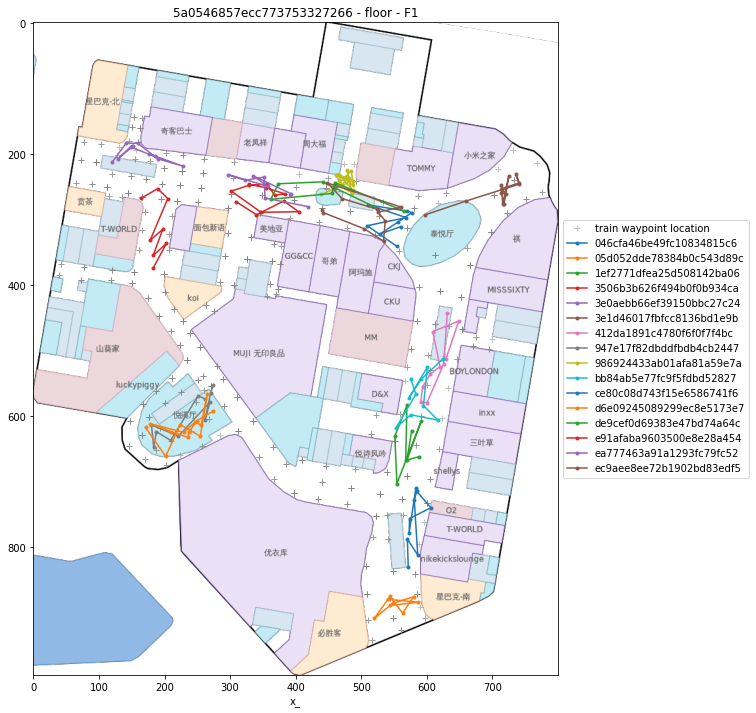

In [93]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

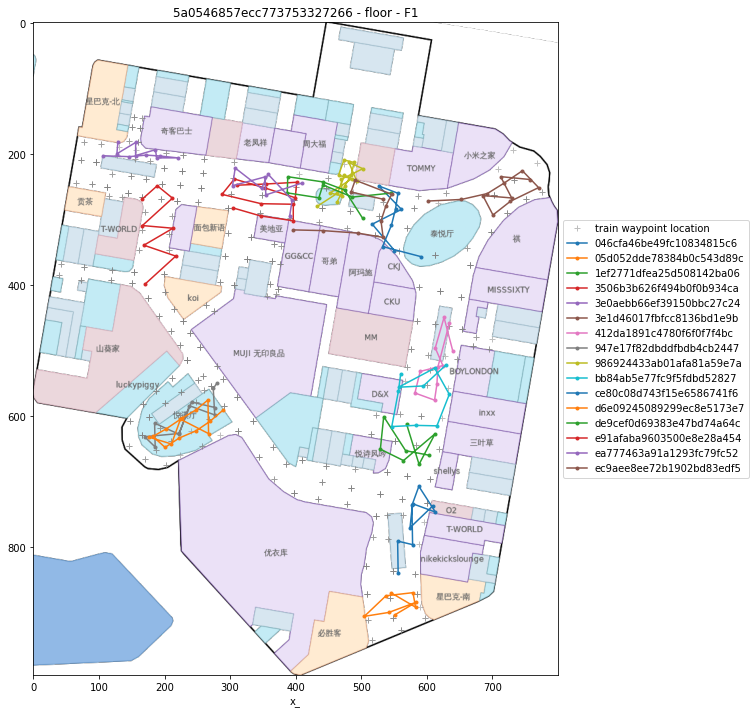

In [94]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

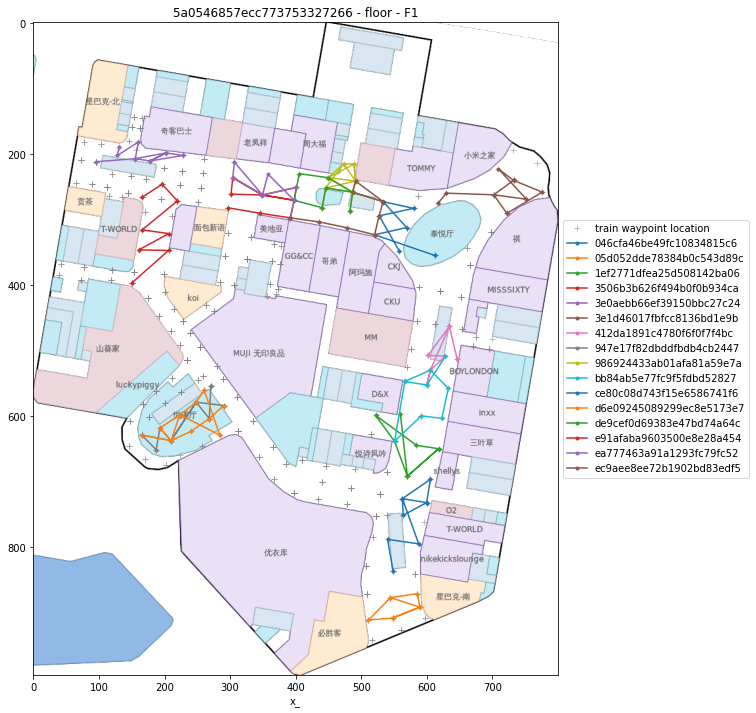

In [95]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)